In [1]:
from ReinforcementLearning.NHL.playerstats.nhl_player_stats import *
from ReinforcementLearning.NHL.playbyplay.game import *
from ReinforcementLearning.NHL.playbyplay.state_space import *

In [2]:
# Pointers to the data
# repoCode    =   '/Users/younes_zerouali/Documents/Stradigi/Code/NHL_stats_SL'
# repoCode    =   '/Users/luisd/dev/NHL_stats'
repoCode    =   '/home/younesz/Documents/Code/NHL_stats_SL'
db_root     =   '/home/younesz/Documents/Databases/Hockey'        #This is the location of the Hockey database
# db_root     =   '/Users/younes_zerouali/Documents/Stradigi/Databases/Hockey'
# db_root     =   '/Users/luisd/dev/NHL_stats/data'
#repoPbP     =   path.join(db_root, 'PlayByPlay')
#repoPSt     =   path.join(db_root, 'PlayerStats/player')
repoModel   =   path.join(repoCode, 'ReinforcementLearning/NHL/playerstats/offVSdef/Automatic_classification/MODEL_backup_trainedonallseasons_rankstatprediction')
repoModel   =   path.join(repoCode, 'ReinforcementLearning/NHL/playerstats/offVSdef/Automatic_classification/MODEL_perceptron_1layer_10units_relu')
repoSave    =   None #path.join(repoCode, 'ReinforcementLearning/NHL/playbyplay/data')

In [3]:
# ==== Second the players data

def get_players_classes(repoModel, data_for_game, preprocessing, classifier, number_of_games):
    """
    Calculates (dataframe with) all player's classes.
    Updates the 'data for game' structure with it; also returns it.
    Usage:
        repoModel = ... # here goes the directory where your model is saved.
        # Montreal received Ottawa on march 13, 2013
        gameId = get_game_id(home_team_abbr='MTL', date_as_str='2013-03-13')
        season      =   '20122013'
        mtlott      =   Game(repoPbP, repoPSt, season, gameId=gameId )
        #
        players_classes = get_players_classes(repoModel, mtlott, number_of_games=30)
        # this is equivalent to ask 'mtlott' for the data; so:
        assert players_classes.equals(mtlott.player_classes)
    """    
    # Pick players stats - last 'n' games 
    data_for_game.pull_line_shifts(team='both', minduration=20)
    data_for_game.pick_regulartime()
    data_for_game.pick_equalstrength()
    data_for_game.pull_players_classes(preprocessing, classifier, nGames=number_of_games)
    return data_for_game

In [4]:
# === Third the model

def get_players_model(repoModel):
    
    # Need to load the data pre-processing variables
    preprocessing  =   pickle.load(open(path.join(repoModel, 'baseVariables.p'), 'rb'))

    # Need to load the classification model (for players' predicted ranking on trophies voting lists)
    classifier          =   {'sess':tf.Session(), 'annX':[], 'annY':[]}
    saver               =   tf.train.import_meta_graph(path.join(repoModel, path.basename(repoModel) + '.meta'))
    graph               =   classifier['sess'].graph
    classifier['annX']  =   graph.get_tensor_by_name('Input_to_the_network-player_features:0')
    classifier['annY']  =   graph.get_tensor_by_name('prediction:0')
    saver.restore(classifier['sess'], tf.train.latest_checkpoint(path.join(repoModel, './')))
    return preprocessing, classifier

# FIRST: List all games


In [5]:
# Select a team
homeTeam  =  'TOR'  

# List all games
HSS    =  HockeySS(db_root)
HSS.list_all_games()

# List team's home games
games  =  HSS.games_lst[HSS.games_lst['hometeam']==homeTeam]  

# Initialize empty dataframe
tmInfo =  pd.DataFrame(columns=['gameCode', 'avgQ', 'points', 'goalsFor', 'goalsAg'])

# SECOND: Determine game Qvalues and points

In [7]:
# Line translation table
HSS.make_line_dictionary()
linedict  =  HSS.line_dictionary

# Qvalue table
# Load the Qvalues table
Qvalues   =  pickle.load( open(path.join(repoCode, 'ReinforcementLearning/NHL/playbyplay/data/RL_action_values.p'), 'rb') )['action_values']

# Load the classification model
preprocessing  =  pickle.load(open(path.join(repoModel, 'baseVariables.p'), 'rb'))
classifier     =  ANN_classifier()
classifier     =  classifier.ann_reload_model(repoModel)
classifier     =  {'sess':classifier[0], 'annX':classifier[1], 'annY':classifier[2]}

INFO:tensorflow:Restoring parameters from /home/younesz/Documents/Code/NHL_stats/ReinforcementLearning/NHL/playerstats/offVSdef/Automatic_classification/MODEL_perceptron_1layer_10units_relu/MODEL_perceptron_1layer_10units_relu


In [20]:
Game(db_root, Season(int(str(iS)[:4])), iG)


In [ ]:
# Loop on games
count  =  0
for iS, iG in zip( games['season'], games['gcode'] ):
    
    # Get game data
    gameData = Game(db_root, Season(int(str(iS)[:4])), iG)
    gameData = get_players_classes(repoModel, gameData, preprocessing, classifier, 30)
    
    if len(gameData.player_classes)>0:
        
        # Get game score    
        goals        =   gameData.df_wc[gameData.df_wc['etype']=='GOAL']['ev.team']
        points       =   int( (goals==homeTeam).sum() > (goals!=homeTeam).sum() ) * 2
        if gameData.df[gameData.df['gcode']==iG].iloc[-1]['period']>3:
            points   =   np.maximum(1, points)
        
        # Get state-space
        playersCode  =   gameData.encode_line_players()
        linesCode    =   np.array( [[gameData.recode_line(linedict, a) for a in b] for b in playersCode] )
        perCode      =   gameData.recode_period(gameData.lineShifts['period'])
        difCode      =   gameData.recode_differential(gameData.lineShifts['differential'])
    
        # Get info for home team
        qv_shifts    =  [Qvalues[w,x,y,z] for w,x,y,z in zip(perCode, difCode, linesCode[:,1], linesCode[:,0])]
    
        # Append this game to the team's data
        tmInfo       =  pd.concat( (tmInfo, pd.DataFrame( np.reshape([iG, np.mean(qv_shifts), points, (goals==homeTeam).sum(), (goals!=homeTeam).sum()], [1,5]), columns=['gameCode', 'avgQ', 'points', 'goalsFor', 'goalsAg'] )), ignore_index=True )
 
    count+=1
    if count % 50 == 0:
        stdout.write('\r')
        # the exact output you're looking for:
        stdout.write("Game %i/%i: [%-40s] %d%%, completed" % (count, len(games), '=' * int(count / len(games) * 40), 100 * count / len(games)))
        stdout.flush()

Game 150/513: [===========                             ] 29%, completed

# VISU: correlation between number of points and Qvalues 

Text(0.5,1,'Correlation between MTL lines value and nb of points per game')

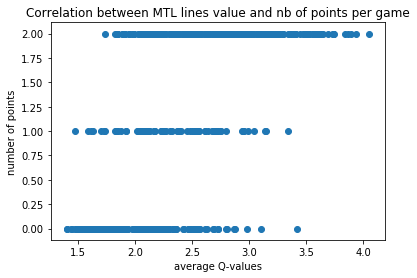

In [8]:
# === For a single team
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(); plt.scatter(tmInfo['avgQ'], tmInfo['points'])
plt.gca().set_xlabel('average Q-values')
plt.gca().set_ylabel('number of points')
plt.gca().set_title('Correlation between MTL lines'' value and nb of points per game')

# VISU: predicting win/lose from Qvalues


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Win/lose prediction based on Qvalues (all data merged)')

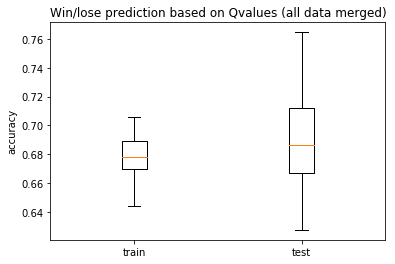

In [11]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

# === Across all teams
# we can't do single-team since analysis was done on a single season

# Concatenate all points
X     =  tmInfo['avgQ']
Y     =  tmInfo['points']

# Make 50 iterations
nIter     =  50
ACC_TR    =  []
ACC_TS    =  []
for it in range(nIter):
    # Make split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=it)

    # Train model
    lr  =  LogisticRegression(C=1., solver='lbfgs')
    #lr  =  CalibratedClassifierCV(LinearSVC(), cv=2, method='sigmoid')
    lr.fit( np.reshape(X_train, [-1,1]), y_train )
    acc_tr = lr.predict( np.reshape(X_train, [-1,1]) )

    # Predict
    y_pred = lr.predict( np.reshape(X_test, [-1,1]) )
    
    # Store
    ACC_TR.append( np.sum( y_train == acc_tr ) / len(y_train) )
    ACC_TS.append( np.sum( y_test == y_pred ) / len(y_test) )
    
    
# Make plot
plt.figure()
plt.boxplot([ACC_TR, ACC_TS])
plt.gca().set_xticklabels(['train', 'test'])
plt.gca().set_ylabel('accuracy')
plt.gca().set_title('Win/lose prediction based on Qvalues (all data merged)')

In [303]:
nIter

50